In [19]:
!pip install tensorflow opencv-contrib-python pandas numpy


In [20]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import os, cv2, numpy as np, pandas as pd
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow


In [22]:
!wget -q -O haarcascade_frontalface_default.xml \
https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


In [23]:
#5️⃣ Webcam Capture (Attendance Only)
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const video = document.createElement('video');
          const stream = await navigator.mediaDevices.getUserMedia({video:true});
          document.body.appendChild(video);
          video.srcObject = stream;
          await video.play();
          await new Promise(resolve => setTimeout(resolve, 2000));
          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video,0,0);
          stream.getTracks()[0].stop();
          video.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
        takePhoto(''' + str(quality) + ''');
    ''')
    display(js)
    data = eval_js("takePhoto()")
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

In [24]:
# 6️⃣ Load Dataset From Google Drive

DATASET_PATH = "/content/drive/MyDrive/dataset"

X = []
y = []
label_map = {}
label = 0

for student_id in os.listdir(DATASET_PATH):
    path = os.path.join(DATASET_PATH, student_id)
    if not os.path.isdir(path):
        continue

    label_map[label] = student_id

    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.resize(img, (224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)

        X.append(img)
        y.append(label)

    label += 1

X = np.array(X)
y = np.array(y)

print("✅ Dataset loaded")
print("Total students:", len(label_map))

✅ Dataset loaded
Total students: 38


In [25]:
# 7️⃣ Build Transfer Learning Model (MobileNetV2)
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # Freeze pretrained layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(len(label_map), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [26]:
# 8️⃣ Train Model
model.fit(X, y, epochs=10, batch_size=8)
print("✅ Transfer Learning model trained")

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 296ms/step - accuracy: 0.1945 - loss: 3.4721
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step - accuracy: 0.7714 - loss: 1.3706
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - accuracy: 0.8893 - loss: 0.6715
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 269ms/step - accuracy: 0.9436 - loss: 0.3166
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 1.0000 - loss: 0.1241
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 264ms/step - accuracy: 1.0000 - loss: 0.0873
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 371ms/step - accuracy: 1.0000 - loss: 0.0323
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - accuracy: 1.0000 - loss: 0.0266
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 328ms/step - accuracy: 1.0000 - loss: 0.0206
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 1.0000 - loss: 0.0139
✅ Transfer Learning model trained


In [27]:
# 9️⃣ Attendance CSV Function
ATTENDANCE_FILE = "/content/attendance.csv"

def mark_attendance(student_id):
    date_now = datetime.now().strftime("%Y-%m-%d")
    time_now = datetime.now().strftime("%H:%M:%S")

    if os.path.exists(ATTENDANCE_FILE):
        df = pd.read_csv(ATTENDANCE_FILE)
    else:
        df = pd.DataFrame(columns=["Student_ID", "Date", "Time"])

    if not ((df["Student_ID"] == student_id) & (df["Date"] == date_now)).any():
        df.loc[len(df)] = [student_id, date_now, time_now]
        df.to_csv(ATTENDANCE_FILE, index=False)
        print(f"✅ Attendance marked: {student_id}")

📷 Capturing image...


<IPython.core.display.Javascript object>

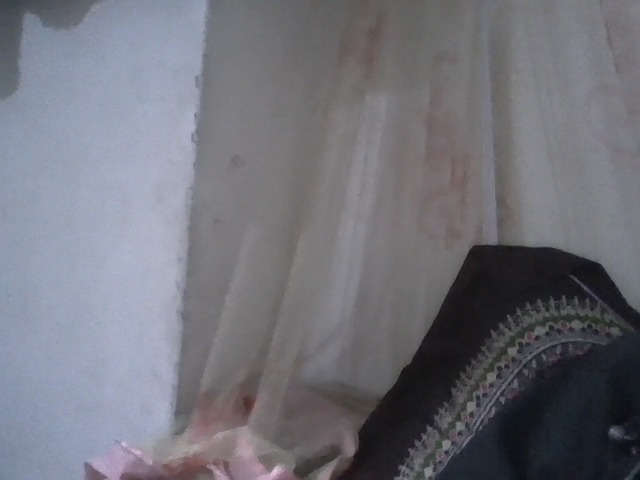

In [39]:
# 🔟 Take Attendance (Live Image)
print("📷 Capturing image...")
take_photo("test.jpg")

img = cv2.imread("test.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in faces:
    face = img[y:y+h, x:x+w]
    face = cv2.resize(face, (224,224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)

    preds = model.predict(face)
    label = np.argmax(preds)
    student_id = label_map[label]

    mark_attendance(student_id)

    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.putText(img, student_id, (x,y-10),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

cv2_imshow(img)

In [40]:
# View Attendance CSV
df = pd.read_csv(ATTENDANCE_FILE)
display(df)

,Student_ID,Date,Time
0,22-49861-3,2026-01-04,20:38:57
1,22-49643-3,2026-01-04,20:44:01
2,22-46536-1,2026-01-04,20:44:21
3,22-47892-2,2026-01-04,20:44:28
